<a href="https://colab.research.google.com/github/aenoboa1/Draft_ML_EmotionAPP/blob/main/testing_daisee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 9.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from google.colab import drive
import visualkeras
drive._mount('/content/drive')


#matplotlib styles
plt.style.use(['ggplot'])
sns.set(rc={'figure.figsize':(11.7,8.27)})

Mounted at /content/drive


In [ ]:
!mkdir /content/DAiSEE ; unzip  -qq /content/drive/MyDrive/DATA/datasets/DAiSEE.zip -d /content/DAiSEE


In [ ]:
# SSH Tunnel para abrir en VS Code
!pip install colab_ssh --upgrade

from colab_ssh import launch_ssh
launch_ssh('21v23nE9rkUZAwWwJZ1zAxGLuwK_7v2uhNRStUAsGmaEtCm5D', 'ml')

we highly recommend that update your code by following this documentation https://github.com/WassimBenzarti/colab-ssh#getting-started
Successfully running 6.tcp.ngrok.io:10394
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

  Host google_colab_ssh
    HostName 6.tcp.ngrok.io
    User root
    Port 10394
    


In [ ]:
class_names = ['Boredom',
               'Engagement',
              'Confusion',
               'Frustration'
               ]


In [ ]:
df_train = pd.read_csv('/content/DAiSEE/DAiSEE/Labels/TrainLabels.csv')


In [ ]:
df_train

,ClipID,Boredom,Engagement,Confusion,Frustration
0,1100011002.avi,0,2,0,0
1,1100011003.avi,0,2,0,0
2,1100011004.avi,0,3,0,0
3,1100011005.avi,0,3,0,0
4,1100011006.avi,0,3,0,0
...,...,...,...,...,...
5353,4599990246.avi,0,3,0,0
5354,4599990247.avi,0,3,0,0
5355,4599990248.avi,1,2,1,1
5356,4599990249.avi,0,3,0,0


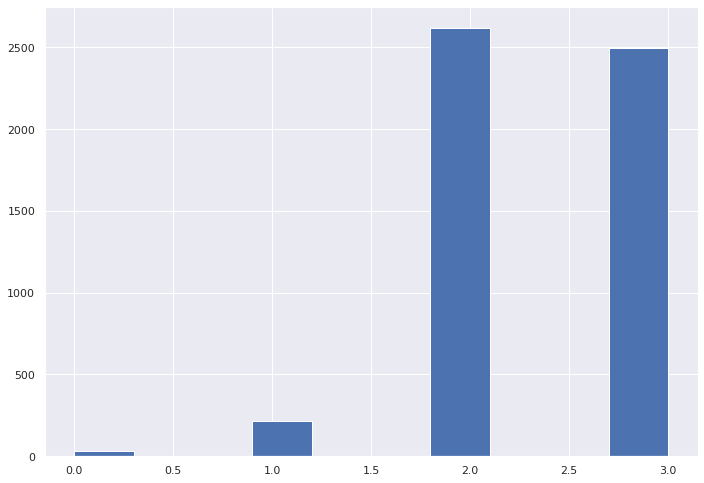

In [ ]:
df_train['Engagement'].hist()


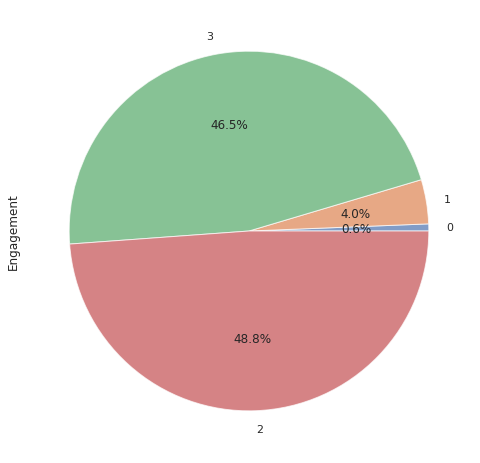

In [ ]:
df_train['Engagement'].value_counts().sort_values().plot.pie(wedgeprops={'alpha':0.7}, autopct='%1.1f%%')


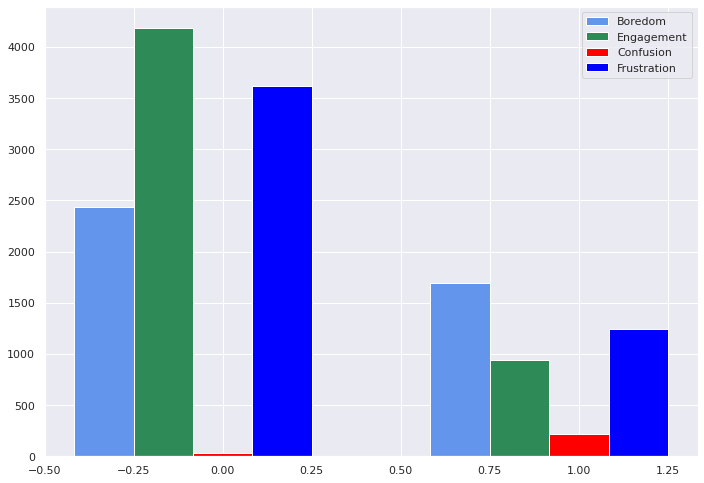

In [ ]:


fig, ax = plt.subplots()

d_heights, d_bins = np.histogram(df_train['Boredom'],bins=[-0.5,0.5,1.5])
m_heights, m_bins = np.histogram(df_train['Frustration '], bins=d_bins)
s_heights, s_bins = np.histogram(df_train['Engagement'], bins=m_bins)
ss_heights, ss_bins = np.histogram(df_train['Confusion'], bins=s_bins)


width = (d_bins[1] - d_bins[0])/6.0

ax.bar(d_bins[:-1]+width, d_heights, width=width, facecolor='cornflowerblue')
ax.bar(m_bins[:-1]+width*2, m_heights, width=width, facecolor='seagreen')
ax.bar(s_bins[:-1]+width*3, s_heights, width=width, facecolor='red')
ax.bar(ss_bins[:-1]+width*4, ss_heights, width=width, facecolor='blue')
ax.legend(class_names)


#### Aplicando la tecnica SMOTE al dataset

In [ ]:
df_train["Engagement"].value_counts()

2    2617
3    2494
1     213
0      34
Name: Engagement, dtype: int64

In [ ]:
count_class_2, count_class_3,count_class_1,count_class_0 = df_train["Engagement"].value_counts()

In [ ]:
count_class_2

2617

In [ ]:
count_class1

213

To install imbalanced-learn library use pip install imbalanced-learn command



In [ ]:
!pip install imbalanced-learn

### Transformando dataset a TFRecords para el training

In [ ]:
!git clone https://github.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset

Cloning into 'Engagement-recognition-using-DAISEE-dataset'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 79 (delta 33), reused 47 (delta 13), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import cv2
import os
from tqdm import tqdm
import tensorflow_datasets as tfds
import pandas as pd
import random


AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
np.random.seed(0)

In [ ]:
class DataPreprocessing:
    def __init__(self,
                 IMG_HEIGHT=224,
                 IMG_WIDTH=224,
                 dataset_dir='/content/DAiSEE/DAiSEE/DataSet/Data/',
                 test_dir='Test/',
                 train_dir='Train/',
                 val_dir='Validation/',
                 labels_dir='/content/DAiSEE/DAiSEE/Labels/',
                 test_label='TestLabels.csv',
                 train_label='TrainLabels.csv',
                 val_label='ValidationLabels.csv',
                 data_augmentation_flag=False,
                 max_frames=3
                 ):
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.dataset_dir = dataset_dir
        self.train_dir = self.dataset_dir+train_dir
        self.test_dir = self.dataset_dir+test_dir
        self.val_dir = self.dataset_dir+val_dir
        self.labels_dir = labels_dir
        self.train_label_dir = self.labels_dir + train_label
        self.test_label_dir = self.labels_dir + test_label
        self.val_label_dir = self.labels_dir + val_label
        self.data_augmentation_flag = data_augmentation_flag
        self.max_frames = max_frames
        self.face_cascade = cv2.CascadeClassifier('/content/Engagement-recognition-using-DAISEE-dataset/dataset/haarcascade_frontalface_default.xml')

    def get_images_from_set_dir(self, setdir):
        '''
        Method to find all images in the tree folder
        '''
        set_dir_images = []
        humans = os.listdir(setdir)
        for human in humans:
            human_dir = setdir + human + "/"
            videos = os.listdir(human_dir)
            for video in videos:
                video_dir = human_dir + video + "/"
                pictures = os.listdir(video_dir)
                pictures = random.sample(pictures, self.max_frames)
                for picture in pictures:
                    picture_dir = video_dir + picture
                    if picture.endswith(".jpg"):
                        set_dir_images.append(picture_dir)
        return set_dir_images

    def get_labels_dataframe(self):
        '''
        Method to read pandas dataframe
        '''
        train_df = pd.read_csv(self.train_label_dir, sep=",")
        test_df = pd.read_csv(self.test_label_dir, sep=",")
        val_df = pd.read_csv(self.val_label_dir, sep=",")
        return train_df, test_df, val_df

    def resize(self, image):
        return cv2.resize(image, (self.IMG_HEIGHT, self.IMG_WIDTH), interpolation=cv2.INTER_AREA)

    def face_cropping(self, image):
        # Crop and resize
        faces = self.face_cascade.detectMultiScale(image, 1.3, 5)
        try:
            if faces != 0:
                x, y, w, h = faces[0]
                image = image[y:y+h, x:x+w]
        except:
            pass
        return self.resize(image)

    def random_crop(self, image, crop_height, crop_width):
        max_x = image.shape[1] - crop_width
        max_y = image.shape[0] - crop_height

        x = np.random.randint(0, max_x)
        y = np.random.randint(0, max_y)

        crop = image[y: y + crop_height, x: x + crop_width]

        return self.face_cropping(crop)


    def augment_image(self, image):
        '''
        Applies some augmentation techniques
        '''
        # Mirror flip
        flipped = tf.image.flip_left_right(image).numpy()
        # Transpose flip
        transposed = tf.image.transpose(image).numpy()
        # Saturation
        satured = tf.image.adjust_saturation(image, 3).numpy()
        # Brightness
        brightness = tf.image.adjust_brightness(image, 0.4).numpy()
        # Contrast
        contrast = tf.image.random_contrast(image, lower=0.0, upper=1.0).numpy()
        # Resize at the end
        images = [self.resize(image) for image in [flipped, transposed, satured, brightness, contrast]]
        return images


    def get_label_picture(self, image_path, label_df):
        error_ = False
        video = image_path.split("/")[-2]
        label_series = label_df.loc[((label_df['ClipID'] == video+'.avi') | (label_df['ClipID'] == video+'.mp4'))]
        try:
            index = label_series.index.values[0]
            label = np.array([label_series['Boredom'].get(index),
                              label_series['Engagement'].get(index),
                              label_series['Confusion'].get(index),
                              label_series['Frustration '].get(index)])
            label_one_hot = (label >= 1).astype(np.uint8)
        except:
            print('Error in label picture')
            print(image_path)
            label_one_hot = ''
            error_ = True
        return label_one_hot, error_

    def _int64_feature(self, value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def _bytes_feature(self, value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def writeTfRecord(self, output_dir, data_augmentation=False):
        '''
        Method to write tfrecord
        '''
        # open the TFRecords file
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Read dataframes
        train_df, test_df, val_df = self.get_labels_dataframe()

        # Objects to iterate
        objs = [('train', self.train_dir, train_df),
                ('test', self.test_dir, test_df),
                ('val', self.val_dir, val_df)]

        for name, dataset, label_df in tqdm(objs):
            # Open Writer
            writer = tf.io.TFRecordWriter(output_dir+name+'.tfrecords')
            # Get all the images of a set
            images_path = self.get_images_from_set_dir(dataset)
            for image_path in tqdm(images_path, total=len(images_path)):
                # Read the image from path
                img = cv2.imread(image_path)[..., ::-1]
                img = self.face_cropping(img)
                # Read the label
                label, error_ = self.get_label_picture(image_path, label_df)
                if error_:
                    continue
                # Create a feature
                if data_augmentation:
                    images = self.augment_image(img)
                else:
                    images = img
                for image in images:
                    feature = {'label': self._bytes_feature(tf.compat.as_bytes(label.tostring())),
                               'image': self._bytes_feature(tf.compat.as_bytes(image.tostring()))}
                    # Create an example protocol buffer
                    example = tf.train.Example(features=tf.train.Features(feature=feature))

                    # Serialize to string and write on the file
                    writer.write(example.SerializeToString())
            writer.close()

    def decode(self, serialized_example):
        """
        Parses an image and label from the given `serialized_example`.
        It is used as a map function for `dataset.map`
        """
        IMAGE_SHAPE = (self.IMG_HEIGHT, self.IMG_WIDTH, 3)

        # 1. define a parser
        features = tf.io.parse_single_example(
            serialized_example,
            # Defaults are not specified since both keys are required.
            features={
                'image': tf.io.FixedLenFeature([], tf.string),
                'label': tf.io.FixedLenFeature([], tf.string),
            })

        # 2. Convert the data
        image = tf.io.decode_raw(features['image'], tf.uint8)
        label = tf.io.decode_raw(features['label'], tf.uint8)

        # Cast
        label = tf.cast(label, tf.float32)

        # 3. reshape
        image = tf.convert_to_tensor(tf.reshape(image, IMAGE_SHAPE))

        return image, label

In [ ]:
preprocessing_class = DataPreprocessing()
# Write tf recordfloat32
preprocessing_class.writeTfRecord('tfrecords/', data_augmentation=True)

# Read TfRecord
tfrecord_path = 'tfrecords/train.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)

# Parse the record into tensors with map.
# map takes a Python function and applies it to every sample.
dataset = dataset.map(preprocessing_class.decode)

# Divide in batch
dataset = dataset.batch(batch_size)

# Create an iterator
iterator = iter(dataset)

# Element of iterator
a = iterator.get_next()

 33%|███▎      | 5419/16401 [04:48<08:32, 21.43it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/459999028/459999028280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/459999028/45999902840.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/459999028/459999028123.jpg



 33%|███▎      | 5425/16401 [04:49<08:08, 22.49it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990254/459999025419.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990254/4599990254127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990254/459999025422.jpg



 33%|███▎      | 5440/16401 [04:49<07:42, 23.72it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990275/4599990275237.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990275/4599990275295.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990275/4599990275107.jpg



 33%|███▎      | 5473/16401 [04:51<07:41, 23.70it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990276/4599990276219.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990276/459999027699.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990276/4599990276212.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990255/4599990255173.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990255/4599990255250.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990255/459999025557.jpg



 33%|███▎      | 5485/16401 [04:51<07:34, 24.00it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990256/4599990256262.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990256/4599990256142.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990256/4599990256123.jpg



 34%|███▎      | 5500/16401 [04:52<07:37, 23.81it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990264/459999026488.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990264/4599990264275.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990264/4599990264265.jpg



 34%|███▎      | 5515/16401 [04:53<07:38, 23.73it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990253/459999025373.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990253/459999025342.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990253/4599990253109.jpg



 34%|███▎      | 5527/16401 [04:53<07:36, 23.84it/s]


Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990270/45999902709.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990270/4599990270186.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990270/459999027078.jpg


 34%|███▍      | 5545/16401 [04:54<07:39, 23.62it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990274/4599990274152.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990274/4599990274239.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990274/459999027464.jpg



 34%|███▍      | 5548/16401 [04:54<07:22, 24.54it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990263/4599990263241.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990263/4599990263108.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990263/459999026390.jpg



 34%|███▍      | 5587/16401 [04:56<07:54, 22.80it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990273/4599990273259.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990273/459999027351.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990273/4599990273272.jpg



 34%|███▍      | 5602/16401 [04:56<07:34, 23.78it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990269/4599990269154.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990269/459999026980.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990269/459999026989.jpg



 34%|███▍      | 5620/16401 [04:57<07:33, 23.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990272/459999027229.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990272/459999027248.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990272/4599990272241.jpg



 34%|███▍      | 5656/16401 [04:59<07:41, 23.29it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990283/459999028319.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990283/459999028343.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/459999/4599990283/4599990283131.jpg



 43%|████▎     | 7132/16401 [06:10<07:06, 21.74it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290284/5221290284231.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290284/5221290284272.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290284/5221290284267.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290210/5221290210164.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290210/5221290210107.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290210/522129021072.jpg



 44%|████▎     | 7135/16401 [06:10<06:40, 23.13it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290251/522129025117.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290251/5221290251170.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290251/522129025114.jpg



 44%|████▎     | 7141/16401 [06:10<09:18, 16.59it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290179/5221290179112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290179/5221290179299.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290179/5221290179185.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290184/5221290184105.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290184/522129018476.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290184/5221290184222.jpg



 44%|████▎     | 7147/16401 [06:10<07:24, 20.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290272/522129027258.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290272/522129027298.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290272/522129027233.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290140/5221290140128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290140/5221290140252.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290140/5221290140140.jpg



 44%|████▎     | 7153/16401 [06:11<06:30, 23.71it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129026/52212902687.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129026/52212902616.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129026/522129026151.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290173/5221290173254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290173/522129017328.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290173/5221290173225.jpg



 44%|████▎     | 7159/16401 [06:11<05:58, 25.80it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129024/522129024180.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129024/52212902479.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129024/52212902454.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290253/5221290253268.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290253/5221290253189.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290253/5221290253221.jpg



 44%|████▎     | 7165/16401 [06:11<05:52, 26.17it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129022/52212902259.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129022/522129022294.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129022/522129022242.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290155/5221290155170.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290155/522129015568.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290155/5221290155246.jpg



 44%|████▎     | 7171/16401 [06:11<05:36, 27.39it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290227/5221290227264.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290227/522129022737.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290227/5221290227148.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290256/522129025652.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290256/522129025659.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290256/522129025658.jpg



 44%|████▍     | 7177/16401 [06:12<05:41, 26.97it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290114/5221290114127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290114/5221290114106.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290114/5221290114104.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290174/5221290174166.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290174/5221290174136.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290174/5221290174269.jpg



 44%|████▍     | 7183/16401 [06:12<05:37, 27.35it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290258/522129025828.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290258/5221290258192.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290258/5221290258211.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290167/5221290167277.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290167/522129016717.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290167/5221290167105.jpg



 44%|████▍     | 7189/16401 [06:12<05:27, 28.11it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290217/522129021784.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290217/522129021738.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290217/522129021744.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290171/5221290171116.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290171/5221290171230.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290171/5221290171158.jpg



 44%|████▍     | 7195/16401 [06:12<05:31, 27.73it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290214/5221290214219.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290214/522129021474.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290214/5221290214150.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290255/522129025588.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290255/5221290255168.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290255/5221290255257.jpg



 44%|████▍     | 7201/16401 [06:12<05:37, 27.30it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290121/5221290121228.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290121/5221290121132.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290121/522129012149.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129013/522129013230.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129013/52212901371.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129013/52212901313.jpg



 44%|████▍     | 7207/16401 [06:13<05:30, 27.80it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290221/522129022155.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290221/522129022147.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290221/5221290221173.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290115/522129011586.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290115/5221290115278.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290115/5221290115201.jpg



 44%|████▍     | 7213/16401 [06:13<05:33, 27.59it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290169/5221290169137.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290169/5221290169158.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290169/5221290169150.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290149/522129014916.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290149/5221290149196.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290149/522129014944.jpg



 44%|████▍     | 7219/16401 [06:13<05:34, 27.45it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290112/522129011272.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290112/522129011279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290112/522129011240.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290266/5221290266111.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290266/5221290266277.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290266/5221290266108.jpg



 44%|████▍     | 7225/16401 [06:13<05:33, 27.54it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290259/5221290259118.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290259/5221290259154.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290259/522129025943.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290151/5221290151179.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290151/522129015176.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290151/5221290151293.jpg



 44%|████▍     | 7231/16401 [06:13<05:36, 27.22it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290161/522129016130.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290161/5221290161235.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290161/5221290161178.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290239/5221290239119.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290239/52212902397.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290239/5221290239144.jpg



 44%|████▍     | 7237/16401 [06:14<05:36, 27.24it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290254/5221290254226.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290254/5221290254122.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290254/5221290254215.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290269/522129026941.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290269/522129026947.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290269/5221290269294.jpg



 44%|████▍     | 7243/16401 [06:14<05:29, 27.78it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290275/5221290275149.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290275/5221290275289.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290275/5221290275286.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290270/5221290270144.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290270/5221290270225.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290270/5221290270272.jpg



 44%|████▍     | 7249/16401 [06:14<05:36, 27.22it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290119/5221290119299.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290119/522129011910.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290119/5221290119208.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290142/5221290142278.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290142/522129014232.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290142/5221290142226.jpg



 44%|████▍     | 7255/16401 [06:14<05:32, 27.47it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129017/522129017263.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129017/52212901743.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129017/522129017140.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290110/522129011059.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290110/5221290110183.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290110/5221290110101.jpg



 44%|████▍     | 7261/16401 [06:15<05:39, 26.93it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290116/5221290116213.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290116/522129011623.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290116/5221290116273.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290263/522129026335.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290263/5221290263299.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290263/5221290263102.jpg



 44%|████▍     | 7267/16401 [06:15<05:40, 26.81it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290122/5221290122146.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290122/5221290122280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290122/522129012227.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129021/522129021206.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129021/522129021128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129021/52212902116.jpg



 44%|████▍     | 7273/16401 [06:15<05:59, 25.41it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290264/5221290264251.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290264/5221290264170.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290264/5221290264234.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290230/5221290230133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290230/5221290230139.jpg



 44%|████▍     | 7276/16401 [06:15<07:42, 19.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290230/522129023013.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290228/5221290228103.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290228/5221290228251.jpg



 44%|████▍     | 7283/16401 [06:15<06:02, 25.15it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290228/52212902284.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290158/522129015843.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290158/5221290158280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290158/5221290158238.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290242/5221290242172.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290242/5221290242262.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290242/522129024291.jpg



 44%|████▍     | 7289/16401 [06:16<05:44, 26.44it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290252/5221290252200.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290252/522129025237.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290252/5221290252300.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290150/52212901507.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290150/522129015019.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290150/522129015040.jpg



 44%|████▍     | 7295/16401 [06:16<05:37, 26.95it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290126/5221290126199.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290126/522129012633.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290126/522129012632.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290134/522129013416.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290134/522129013499.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290134/522129013430.jpg



 45%|████▍     | 7301/16401 [06:16<05:30, 27.51it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290141/5221290141120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290141/5221290141224.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290162/5221290162186.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290162/5221290162111.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290162/5221290162156.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290282/5221290282208.jpg



 45%|████▍     | 7307/16401 [06:16<05:29, 27.58it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290282/5221290282245.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290282/5221290282212.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290257/5221290257181.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290257/522129025729.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290257/5221290257252.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290138/522129013875.jpg



 45%|████▍     | 7313/16401 [06:17<05:27, 27.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290138/5221290138218.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290138/5221290138287.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290180/522129018055.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290180/5221290180197.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290180/5221290180231.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290247/5221290247114.jpg



 45%|████▍     | 7320/16401 [06:17<05:11, 29.18it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290247/522129024763.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290247/5221290247104.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290274/5221290274237.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290274/5221290274113.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290274/522129027468.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129027/522129027224.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129027/52212902750.jpg



 45%|████▍     | 7326/16401 [06:17<05:14, 28.86it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129027/522129027118.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290268/522129026848.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290268/5221290268225.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290268/5221290268125.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290118/5221290118225.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290118/522129011847.jpg



 45%|████▍     | 7332/16401 [06:17<05:28, 27.57it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290118/5221290118174.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290165/522129016562.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290165/5221290165137.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290165/5221290165184.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290147/5221290147179.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290147/522129014791.jpg



 45%|████▍     | 7338/16401 [06:17<05:30, 27.45it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290147/5221290147219.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290172/5221290172280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290172/5221290172184.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290172/5221290172179.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290135/5221290135101.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290135/5221290135141.jpg



 45%|████▍     | 7344/16401 [06:18<05:33, 27.13it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290135/5221290135242.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290226/5221290226133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290226/52212902264.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290226/522129022659.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290164/5221290164242.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290164/5221290164221.jpg



 45%|████▍     | 7350/16401 [06:18<05:27, 27.66it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290164/5221290164192.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290280/5221290280117.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290280/5221290280128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290280/5221290280115.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290235/5221290235124.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290235/5221290235185.jpg



 45%|████▍     | 7356/16401 [06:18<05:25, 27.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290235/5221290235271.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290163/5221290163110.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290163/5221290163214.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290163/522129016371.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290250/522129025096.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290250/5221290250153.jpg



 45%|████▍     | 7363/16401 [06:18<05:12, 28.93it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290250/5221290250164.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290123/522129012325.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290123/522129012396.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290123/5221290123106.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290240/5221290240233.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290240/5221290240155.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290240/52212902405.jpg



 45%|████▍     | 7369/16401 [06:19<05:17, 28.41it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290249/52212902499.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290249/5221290249145.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290249/5221290249121.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290213/5221290213129.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290213/522129021351.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290213/522129021391.jpg



 45%|████▍     | 7375/16401 [06:19<05:13, 28.81it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290223/5221290223138.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290223/5221290223288.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290223/5221290223161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290231/5221290231190.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290231/5221290231130.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290231/522129023146.jpg



 45%|████▌     | 7381/16401 [06:19<05:15, 28.56it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290216/522129021680.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290216/522129021650.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290216/5221290216239.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290131/5221290131127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290131/5221290131123.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290131/522129013122.jpg



 45%|████▌     | 7387/16401 [06:19<05:21, 28.07it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290271/5221290271256.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290271/5221290271184.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290271/522129027163.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290132/5221290132167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290132/5221290132265.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290132/5221290132173.jpg



 45%|████▌     | 7393/16401 [06:19<05:19, 28.19it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290222/5221290222184.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290222/522129022282.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290222/5221290222223.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290215/5221290215217.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290215/5221290215297.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290215/522129021568.jpg



 45%|████▌     | 7399/16401 [06:20<05:25, 27.67it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290124/5221290124250.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290124/5221290124111.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290124/5221290124159.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290178/5221290178234.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290178/5221290178133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290178/522129017862.jpg



 45%|████▌     | 7405/16401 [06:20<05:20, 28.10it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290220/5221290220181.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290220/5221290220274.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290220/522129022057.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129025/522129025204.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129025/522129025267.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129025/522129025195.jpg



 45%|████▌     | 7411/16401 [06:20<05:22, 27.90it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290212/5221290212206.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290212/522129021219.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290212/5221290212296.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290237/522129023723.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290237/5221290237160.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290237/522129023779.jpg



 45%|████▌     | 7417/16401 [06:20<05:34, 26.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290111/522129011124.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290111/5221290111291.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290111/522129011126.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290127/5221290127248.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290127/52212901273.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290127/5221290127132.jpg



 45%|████▌     | 7423/16401 [06:21<05:34, 26.84it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290129/5221290129139.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290129/5221290129265.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290129/522129012998.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290145/522129014596.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290145/5221290145157.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290145/5221290145191.jpg



 45%|████▌     | 7429/16401 [06:21<05:27, 27.44it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129018/522129018224.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129018/522129018152.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129018/522129018269.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290166/5221290166236.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290166/5221290166210.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290166/5221290166226.jpg



 45%|████▌     | 7435/16401 [06:21<05:17, 28.21it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290238/5221290238219.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290238/522129023811.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290238/5221290238104.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290273/5221290273159.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290273/5221290273169.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290273/5221290273124.jpg



 45%|████▌     | 7441/16401 [06:21<05:19, 28.08it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290279/5221290279276.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290279/5221290279293.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290279/5221290279189.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290177/5221290177244.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290177/5221290177216.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290177/5221290177284.jpg



 45%|████▌     | 7447/16401 [06:21<05:20, 27.91it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290175/5221290175294.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290175/522129017536.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290175/52212901751.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290137/5221290137268.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290137/5221290137222.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290137/5221290137283.jpg



 45%|████▌     | 7453/16401 [06:22<05:30, 27.07it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129016/522129016106.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129016/522129016221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/522129016/522129016285.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290144/5221290144107.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290144/522129014461.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Train/522129/5221290144/522129014424.jpg



 22%|██▏       | 1253/5580 [01:04<03:07, 23.04it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260275/9988260275112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260275/9988260275193.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260275/99882602756.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260216/998826021681.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260216/99882602169.jpg



 23%|██▎       | 1259/5580 [01:05<03:22, 21.32it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260216/9988260216120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260150/9988260150153.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260150/998826015063.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260150/9988260150102.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260235/998826023593.jpg



 23%|██▎       | 1265/5580 [01:05<03:15, 22.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260235/9988260235291.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260235/99882602354.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260281/9988260281271.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260281/998826028167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260281/9988260281238.jpg



 23%|██▎       | 1271/5580 [01:05<03:06, 23.09it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260154/998826015470.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260154/9988260154286.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260154/9988260154237.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260163/998826016314.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260163/9988260163206.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260163/9988260163210.jpg



 23%|██▎       | 1280/5580 [01:06<03:05, 23.20it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260157/9988260157279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260157/9988260157222.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260157/9988260157267.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260212/998826021297.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260212/9988260212297.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260212/9988260212170.jpg



 23%|██▎       | 1283/5580 [01:06<03:07, 22.96it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826017/998826017215.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826017/998826017115.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826017/998826017119.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260277/9988260277189.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260277/9988260277297.jpg



 23%|██▎       | 1289/5580 [01:06<03:05, 23.19it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260277/9988260277253.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260250/9988260250183.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260250/998826025028.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260250/9988260250269.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260245/9988260245138.jpg



 23%|██▎       | 1295/5580 [01:06<03:01, 23.65it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260245/9988260245295.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260245/9988260245151.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260246/9988260246164.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260246/998826024678.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260246/9988260246256.jpg



 23%|██▎       | 1301/5580 [01:07<02:58, 24.00it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260152/9988260152110.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260152/99882601524.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260152/998826015288.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260137/9988260137252.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260137/9988260137273.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260137/9988260137275.jpg



 23%|██▎       | 1304/5580 [01:07<02:57, 24.07it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260257/9988260257278.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260257/998826025783.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260257/998826025731.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260254/998826025414.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260254/9988260254257.jpg



 23%|██▎       | 1310/5580 [01:07<03:11, 22.30it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260254/9988260254253.jpg



 24%|██▎       | 1316/5580 [01:07<03:05, 23.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260268/998826026830.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260268/9988260268102.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260268/998826026878.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260273/9988260273221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260273/9988260273110.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260273/9988260273113.jpg



 24%|██▎       | 1322/5580 [01:07<02:59, 23.72it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260247/9988260247144.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260247/9988260247194.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260247/99882602477.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260269/998826026984.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260269/9988260269138.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260269/99882602699.jpg



 24%|██▍       | 1328/5580 [01:08<02:54, 24.30it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260248/998826024835.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260248/9988260248240.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260248/9988260248228.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260141/9988260141221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260141/9988260141212.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260141/9988260141121.jpg



 24%|██▍       | 1334/5580 [01:08<02:53, 24.43it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260227/99882602277.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260227/9988260227258.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260227/998826022748.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260211/9988260211260.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260211/9988260211197.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260211/998826021168.jpg



 24%|██▍       | 1340/5580 [01:08<02:49, 25.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260228/9988260228261.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260228/998826022815.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260228/9988260228207.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260167/9988260167221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260167/9988260167251.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260167/9988260167166.jpg



 24%|██▍       | 1346/5580 [01:08<02:53, 24.39it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260160/998826016023.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260160/9988260160300.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260160/998826016083.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826026/99882602649.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826026/998826026254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826026/998826026186.jpg



 24%|██▍       | 1349/5580 [01:09<02:54, 24.18it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826023/998826023218.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826023/998826023298.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826023/998826023103.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260129/9988260129248.jpg



 24%|██▍       | 1355/5580 [01:09<03:47, 18.54it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260129/9988260129120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260129/9988260129186.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260145/9988260145288.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260145/998826014544.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260145/998826014592.jpg



 24%|██▍       | 1358/5580 [01:09<03:33, 19.79it/s]


Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260234/998826023476.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260234/9988260234197.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260234/9988260234112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260249/9988260249144.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260249/998826024950.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260249/9988260249126.jpg


 24%|██▍       | 1367/5580 [01:10<03:08, 22.31it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260251/998826025113.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260251/998826025125.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260259/9988260259169.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260259/9988260259182.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260259/998826025969.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260138/9988260138216.jpg



 25%|██▍       | 1370/5580 [01:10<03:02, 23.04it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260138/9988260138249.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260138/9988260138147.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260233/9988260233177.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260233/9988260233185.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260233/9988260233147.jpg



 25%|██▍       | 1376/5580 [01:10<03:05, 22.69it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260243/9988260243180.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260243/998826024392.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260243/9988260243283.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260135/9988260135201.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260135/998826013520.jpg



 25%|██▍       | 1382/5580 [01:10<02:56, 23.79it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260135/9988260135259.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260255/998826025525.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260255/9988260255275.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260255/998826025557.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260210/998826021028.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260210/9988260210216.jpg



 25%|██▍       | 1388/5580 [01:10<02:50, 24.61it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260210/9988260210126.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826016/998826016164.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826016/998826016140.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826016/998826016268.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260270/9988260270195.jpg



 25%|██▍       | 1394/5580 [01:11<02:46, 25.15it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260270/9988260270300.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260270/998826027096.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260224/9988260224137.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260224/998826022431.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260224/9988260224228.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260230/9988260230254.jpg



 25%|██▌       | 1397/5580 [01:11<02:47, 24.91it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260230/9988260230202.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260230/998826023023.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260279/9988260279290.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260279/9988260279189.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260279/9988260279270.jpg



 25%|██▌       | 1403/5580 [01:11<02:53, 24.06it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260239/9988260239288.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260239/9988260239106.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260239/998826023928.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260165/9988260165246.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260165/998826016562.jpg



 25%|██▌       | 1409/5580 [01:11<02:51, 24.27it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260165/9988260165227.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260134/9988260134122.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260134/998826013498.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260134/9988260134203.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260146/9988260146102.jpg



 25%|██▌       | 1415/5580 [01:12<02:51, 24.29it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260146/9988260146172.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260146/998826014654.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260139/998826013987.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260139/998826013911.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260139/9988260139245.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826014/99882601419.jpg



 25%|██▌       | 1421/5580 [01:12<02:48, 24.67it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826014/998826014192.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826014/998826014188.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260123/9988260123244.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260123/998826012338.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260123/9988260123288.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260133/9988260133175.jpg



 26%|██▌       | 1427/5580 [01:12<02:53, 23.88it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260133/9988260133177.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260133/9988260133262.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260276/9988260276107.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260276/9988260276133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260276/9988260276215.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260143/9988260143233.jpg



 26%|██▌       | 1433/5580 [01:12<02:51, 24.15it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260143/99882601433.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260143/9988260143268.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826013/998826013133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826013/998826013238.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826013/998826013119.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260127/9988260127297.jpg



 26%|██▌       | 1439/5580 [01:13<02:53, 23.91it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260127/9988260127262.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260127/998826012795.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260237/9988260237253.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260237/998826023734.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260237/9988260237191.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260231/998826023167.jpg



 26%|██▌       | 1445/5580 [01:13<02:51, 24.09it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260231/9988260231166.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260231/99882602316.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260241/998826024158.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260241/998826024129.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260241/998826024143.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260264/9988260264239.jpg



 26%|██▌       | 1448/5580 [01:13<02:52, 23.89it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260264/998826026471.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260264/9988260264248.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826019/9988260196.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826019/998826019167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826019/998826019298.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260222/9988260222108.jpg



 26%|██▌       | 1457/5580 [01:13<02:51, 24.06it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260222/9988260222228.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260222/9988260222286.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260242/9988260242268.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260242/9988260242232.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260242/9988260242154.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260217/998826021762.jpg



 26%|██▌       | 1463/5580 [01:14<02:52, 23.83it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260217/998826021725.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260217/9988260217229.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260130/998826013096.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260130/9988260130180.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260130/9988260130149.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260144/998826014493.jpg



 26%|██▋       | 1466/5580 [01:14<02:52, 23.90it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260144/9988260144212.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260144/9988260144214.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260229/9988260229238.jpg



 26%|██▋       | 1472/5580 [01:14<03:34, 19.14it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260229/998826022945.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260229/9988260229209.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260126/9988260126218.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260126/9988260126298.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260126/9988260126161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260236/998826023615.jpg



 26%|██▋       | 1475/5580 [01:14<03:21, 20.36it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260236/998826023667.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260236/9988260236227.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826022/998826022147.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826022/998826022203.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826022/998826022219.jpg



 27%|██▋       | 1481/5580 [01:14<03:08, 21.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260232/998826023294.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260232/9988260232161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260232/9988260232181.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826021/998826021149.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826021/9988260215.jpg



 27%|██▋       | 1487/5580 [01:15<03:00, 22.65it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826021/99882602117.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260240/998826024030.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260240/99882602409.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260240/998826024062.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826024/998826024229.jpg



 27%|██▋       | 1493/5580 [01:15<02:52, 23.63it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826024/99882602425.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/998826024/998826024279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260132/9988260132297.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260132/9988260132279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260132/9988260132300.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260214/9988260214194.jpg



 27%|██▋       | 1496/5580 [01:15<02:57, 22.98it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260214/9988260214177.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260214/9988260214174.jpg



 27%|██▋       | 1502/5580 [01:15<02:56, 23.11it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260215/998826021531.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260215/9988260215185.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260215/9988260215143.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260121/9988260121173.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260121/9988260121225.jpg



 27%|██▋       | 1508/5580 [01:16<02:59, 22.68it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Test/998826/9988260121/9988260121105.jpg



  5%|▌         | 258/5143 [00:10<03:33, 22.89it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820265/8263820265101.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820265/8263820265168.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820265/8263820265165.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820269/8263820269143.jpg



  5%|▌         | 261/5143 [00:11<03:40, 22.15it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820269/826382026952.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820269/8263820269273.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820123/8263820123270.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820123/826382012356.jpg



  5%|▌         | 267/5143 [00:11<04:03, 20.06it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820123/8263820123141.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820152/826382015273.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820152/8263820152121.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820152/8263820152182.jpg



  5%|▌         | 270/5143 [00:11<04:01, 20.15it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820214/826382021437.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820214/826382021464.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820214/8263820214140.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820233/826382023387.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820233/826382023316.jpg



  5%|▌         | 276/5143 [00:11<04:02, 20.08it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820233/8263820233128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820253/8263820253161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820253/8263820253132.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820253/8263820253208.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820268/826382026848.jpg



  5%|▌         | 282/5143 [00:12<03:48, 21.24it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820268/8263820268249.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820268/8263820268172.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820254/8263820254179.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820254/8263820254150.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820254/826382025424.jpg



  6%|▌         | 285/5143 [00:12<03:49, 21.13it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820235/8263820235118.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820235/8263820235208.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820235/8263820235120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820132/8263820132133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820132/8263820132121.jpg



  6%|▌         | 291/5143 [00:12<04:01, 20.06it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820132/8263820132105.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820135/8263820135258.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820135/826382013562.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820135/8263820135144.jpg



  6%|▌         | 294/5143 [00:12<04:07, 19.60it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820113/8263820113116.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820113/8263820113292.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820113/826382011394.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820120/8263820120121.jpg



  6%|▌         | 298/5143 [00:12<04:21, 18.54it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820120/8263820120238.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820120/8263820120176.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820155/8263820155216.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820155/8263820155146.jpg



  6%|▌         | 302/5143 [00:13<04:20, 18.56it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820155/826382015568.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382028/82638202818.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382028/826382028289.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382028/82638202859.jpg



  6%|▌         | 306/5143 [00:13<04:14, 19.02it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820273/826382027353.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820273/826382027336.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820273/8263820273216.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820146/826382014638.jpg



  6%|▌         | 310/5143 [00:13<04:33, 17.67it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820146/8263820146252.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820146/8263820146127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382018/82638201822.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382018/82638201895.jpg



  6%|▌         | 314/5143 [00:13<05:35, 14.40it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382018/826382018122.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382027/826382027273.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382027/826382027181.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382027/82638202718.jpg



  6%|▌         | 318/5143 [00:14<05:03, 15.90it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820160/8263820160174.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820160/8263820160226.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820160/8263820160268.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820266/826382026696.jpg



  6%|▋         | 323/5143 [00:14<04:32, 17.68it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820266/8263820266120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820266/8263820266101.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382016/8263820162.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382016/82638201633.jpg



  6%|▋         | 327/5143 [00:14<04:38, 17.29it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382016/82638201626.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820275/8263820275281.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820275/8263820275203.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820275/8263820275233.jpg



  6%|▋         | 331/5143 [00:14<04:30, 17.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820213/826382021398.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820213/826382021320.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820213/8263820213136.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820170/8263820170157.jpg



  7%|▋         | 336/5143 [00:15<04:08, 19.32it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820170/8263820170293.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820170/8263820170167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820231/8263820231276.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820231/8263820231261.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820231/826382023191.jpg



  7%|▋         | 341/5143 [00:15<04:02, 19.83it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820140/8263820140201.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820140/826382014058.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820140/8263820140132.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820256/8263820256279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820256/8263820256242.jpg



  7%|▋         | 345/5143 [00:15<04:18, 18.55it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820256/8263820256130.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820136/8263820136295.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820136/826382013673.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820136/8263820136202.jpg



  7%|▋         | 350/5143 [00:15<04:07, 19.34it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820228/82638202285.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820228/826382022834.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820228/82638202288.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382023/82638202377.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382023/82638202379.jpg



  7%|▋         | 354/5143 [00:16<04:11, 19.06it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382023/82638202366.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382015/82638201567.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382015/826382015141.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382015/826382015276.jpg



  7%|▋         | 358/5143 [00:16<04:19, 18.43it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382024/82638202457.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382024/826382024246.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382024/826382024216.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820148/8263820148261.jpg



  7%|▋         | 362/5143 [00:16<04:17, 18.55it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820148/826382014818.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820148/826382014837.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820221/82638202211.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820221/8263820221229.jpg



  7%|▋         | 366/5143 [00:16<04:25, 17.99it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820221/8263820221277.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820147/8263820147145.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820147/826382014715.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820147/826382014738.jpg



  7%|▋         | 371/5143 [00:17<04:11, 18.98it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820227/826382022713.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820227/8263820227242.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820227/8263820227277.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382021/826382021186.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382021/8263820218.jpg



  7%|▋         | 375/5143 [00:17<04:20, 18.31it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820112/8263820112222.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820112/8263820112199.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820112/8263820112265.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820141/8263820141160.jpg



  7%|▋         | 380/5143 [00:17<04:02, 19.65it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820141/826382014164.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820141/826382014119.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820260/826382026062.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820260/8263820260300.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820260/8263820260284.jpg



  7%|▋         | 384/5143 [00:17<04:15, 18.60it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820169/826382016976.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820169/826382016920.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820169/8263820169230.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820145/8263820145249.jpg



  8%|▊         | 389/5143 [00:17<04:01, 19.65it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820145/8263820145178.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820145/8263820145128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820234/8263820234194.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820234/8263820234281.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820234/8263820234195.jpg



  8%|▊         | 394/5143 [00:18<03:53, 20.35it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820272/82638202724.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820272/8263820272118.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820272/8263820272162.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820277/826382027771.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820277/8263820277296.jpg



  8%|▊         | 397/5143 [00:18<03:52, 20.42it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820277/8263820277279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820144/826382014428.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820144/8263820144203.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820144/8263820144201.jpg



  8%|▊         | 402/5143 [00:18<04:03, 19.46it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820212/8263820212169.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820212/82638202124.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820212/826382021290.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820251/826382025113.jpg



  8%|▊         | 406/5143 [00:18<04:11, 18.85it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820251/8263820251206.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820251/826382025146.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820139/8263820139161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820139/8263820139155.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820139/8263820139210.jpg



  8%|▊         | 411/5143 [00:19<05:21, 14.72it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820237/8263820237262.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820237/826382023765.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820237/826382023730.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820239/8263820239292.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820239/8263820239110.jpg



  8%|▊         | 416/5143 [00:19<04:30, 17.50it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820239/8263820239109.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820246/8263820246182.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820246/826382024698.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820246/8263820246137.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820150/826382015023.jpg



  8%|▊         | 420/5143 [00:19<04:30, 17.44it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820150/8263820150170.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820150/82638201507.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820151/8263820151207.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820151/8263820151184.jpg



  8%|▊         | 424/5143 [00:19<04:26, 17.74it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820151/8263820151135.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820159/8263820159248.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820159/826382015920.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820159/8263820159217.jpg



  8%|▊         | 429/5143 [00:20<04:01, 19.50it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820247/8263820247102.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820247/8263820247209.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820247/8263820247188.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820255/8263820255179.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820255/826382025584.jpg



  8%|▊         | 434/5143 [00:20<03:55, 20.00it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820255/82638202554.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820278/8263820278182.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820278/826382027899.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820278/8263820278235.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820124/826382012416.jpg



  9%|▊         | 438/5143 [00:20<04:03, 19.33it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820124/8263820124221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820124/8263820124262.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820245/8263820245285.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820245/8263820245276.jpg



  9%|▊         | 443/5143 [00:20<04:07, 19.03it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820245/8263820245190.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820138/8263820138234.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820138/8263820138260.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820138/826382013823.jpg



  9%|▊         | 448/5143 [00:21<03:54, 19.99it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820279/826382027946.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820279/8263820279125.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820279/8263820279134.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820264/8263820264176.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820264/826382026487.jpg



  9%|▉         | 452/5143 [00:21<04:08, 18.84it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820264/8263820264211.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820156/8263820156112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820156/8263820156286.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820156/826382015611.jpg



  9%|▉         | 456/5143 [00:21<04:04, 19.19it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820243/8263820243286.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820243/8263820243277.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820243/8263820243201.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382026/826382026242.jpg



  9%|▉         | 461/5143 [00:21<03:55, 19.85it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382026/8263820265.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/826382026/826382026291.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820257/8263820257100.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820257/826382025734.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820257/8263820257242.jpg



  9%|▉         | 465/5143 [00:22<04:00, 19.45it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820224/826382022442.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820224/8263820224179.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820210/826382021077.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820210/8263820210285.jpg



  9%|▉         | 469/5143 [00:22<04:01, 19.32it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820210/8263820210112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820242/826382024253.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820242/826382024220.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820242/8263820242120.jpg



  9%|▉         | 473/5143 [00:22<04:06, 18.94it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820126/8263820126216.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820126/8263820126247.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820126/8263820126245.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820211/826382021167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820211/8263820211117.jpg



  9%|▉         | 477/5143 [00:22<04:13, 18.43it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820211/8263820211223.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820240/826382024069.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820240/8263820240192.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820240/8263820240152.jpg



  9%|▉         | 481/5143 [00:22<04:15, 18.25it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820165/826382016588.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820165/8263820165218.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820165/8263820165204.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820223/826382022365.jpg



  9%|▉         | 486/5143 [00:23<04:01, 19.26it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820223/82638202234.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820223/8263820223232.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820259/826382025920.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820259/82638202594.jpg



 10%|▉         | 490/5143 [00:23<04:06, 18.87it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820259/82638202595.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820162/8263820162148.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820162/8263820162161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/826382/8263820162/8263820162222.jpg



 39%|███▉      | 1998/5143 [01:26<02:02, 25.64it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620163/7698620163293.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620163/7698620163254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620163/769862016389.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620258/7698620258290.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620258/7698620258231.jpg



 39%|███▉      | 2004/5143 [01:27<02:11, 23.86it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620258/7698620258148.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862021/769862021110.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862021/76986202184.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862021/769862021154.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620158/7698620158190.jpg



 39%|███▉      | 2007/5143 [01:27<02:15, 23.11it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620158/7698620158249.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620158/7698620158218.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620268/769862026868.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620268/769862026836.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620268/76986202686.jpg



 39%|███▉      | 2013/5143 [01:27<02:17, 22.70it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620252/7698620252198.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620252/7698620252183.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620252/7698620252141.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620239/7698620239198.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620239/769862023943.jpg



 39%|███▉      | 2019/5143 [01:27<02:19, 22.41it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620239/7698620239259.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620126/7698620126112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620126/769862012675.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620126/7698620126195.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620230/7698620230172.jpg



 39%|███▉      | 2022/5143 [01:27<02:24, 21.59it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620230/7698620230287.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620230/7698620230211.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620221/7698620221223.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620221/7698620221178.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620221/769862022171.jpg



 39%|███▉      | 2028/5143 [01:28<02:21, 21.95it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620245/7698620245218.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620245/7698620245244.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620245/769862024564.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862017/769862017238.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862017/769862017240.jpg



 40%|███▉      | 2034/5143 [01:28<02:22, 21.83it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862017/769862017103.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620260/7698620260120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620260/7698620260207.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620260/7698620260141.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620113/769862011322.jpg



 40%|███▉      | 2037/5143 [01:28<02:22, 21.85it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620113/7698620113223.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620113/7698620113279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620130/7698620130222.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620130/7698620130276.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620130/7698620130160.jpg



 40%|███▉      | 2043/5143 [01:28<02:19, 22.30it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620212/76986202125.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620212/769862021247.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620212/7698620212204.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620131/7698620131259.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620131/7698620131162.jpg



 40%|███▉      | 2049/5143 [01:29<02:19, 22.24it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620131/7698620131268.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620264/7698620264132.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620264/7698620264220.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620264/7698620264227.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620241/7698620241241.jpg



 40%|███▉      | 2052/5143 [01:29<02:49, 18.28it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620241/76986202416.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620241/7698620241139.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620139/7698620139240.jpg



 40%|███▉      | 2055/5143 [01:29<02:40, 19.18it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620139/7698620139197.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620139/7698620139295.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862011/769862011285.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862011/769862011232.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862011/769862011242.jpg



 40%|████      | 2061/5143 [01:29<02:44, 18.69it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620229/7698620229100.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620229/7698620229155.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620229/7698620229270.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620165/769862016598.jpg



 40%|████      | 2064/5143 [01:30<02:37, 19.56it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620165/769862016576.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620165/769862016599.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620145/7698620145276.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620145/7698620145282.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620145/769862014573.jpg



 40%|████      | 2070/5143 [01:30<02:28, 20.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620218/769862021844.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620218/7698620218224.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620218/769862021854.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620256/769862025655.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620256/7698620256182.jpg



 40%|████      | 2076/5143 [01:30<02:30, 20.34it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620256/7698620256251.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862016/769862016300.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862016/769862016114.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862016/769862016165.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620278/7698620278113.jpg



 40%|████      | 2079/5143 [01:30<02:27, 20.81it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620278/7698620278157.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620278/76986202789.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620255/7698620255253.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620255/769862025521.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620255/7698620255169.jpg



 41%|████      | 2085/5143 [01:30<02:19, 21.93it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620257/7698620257155.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620257/769862025756.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620257/7698620257261.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620248/7698620248147.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620248/769862024892.jpg



 41%|████      | 2091/5143 [01:31<02:18, 22.04it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620248/7698620248167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620244/7698620244271.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620244/7698620244254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620244/7698620244145.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620262/769862026251.jpg



 41%|████      | 2094/5143 [01:31<02:17, 22.20it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620262/769862026247.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620262/7698620262263.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620152/7698620152107.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620152/7698620152239.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620152/769862015250.jpg



 41%|████      | 2100/5143 [01:31<02:18, 21.96it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620149/7698620149242.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620149/769862014944.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620149/7698620149146.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620144/7698620144127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620144/7698620144257.jpg



 41%|████      | 2106/5143 [01:31<02:20, 21.58it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620144/769862014496.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620274/7698620274155.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620274/7698620274151.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620274/7698620274275.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620224/7698620224238.jpg



 41%|████      | 2109/5143 [01:32<02:20, 21.53it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620224/7698620224225.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620224/769862022429.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620151/7698620151300.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620151/7698620151166.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620151/7698620151177.jpg



 41%|████      | 2115/5143 [01:32<02:17, 22.02it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620261/7698620261137.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620261/7698620261178.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620261/769862026131.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620132/7698620132127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620132/769862013223.jpg



 41%|████      | 2121/5143 [01:32<02:17, 21.93it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620132/7698620132120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620122/7698620122152.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620122/7698620122283.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620122/7698620122259.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620112/7698620112197.jpg



 41%|████▏     | 2124/5143 [01:32<02:16, 22.15it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620112/7698620112193.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620112/7698620112278.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620211/7698620211178.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620211/7698620211169.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620211/7698620211253.jpg



 41%|████▏     | 2130/5143 [01:33<02:16, 22.07it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620225/7698620225280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620225/7698620225221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620225/7698620225185.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620133/7698620133203.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620133/7698620133297.jpg



 42%|████▏     | 2136/5143 [01:33<02:15, 22.12it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620133/7698620133133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620227/769862022716.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620227/7698620227167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620227/7698620227133.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620265/7698620265201.jpg



 42%|████▏     | 2139/5143 [01:33<02:13, 22.55it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620265/769862026548.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620265/7698620265160.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620253/7698620253290.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620253/7698620253113.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620253/769862025319.jpg



 42%|████▏     | 2145/5143 [01:33<02:16, 22.03it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620169/769862016972.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620169/7698620169291.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620169/7698620169181.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620129/7698620129124.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620129/7698620129159.jpg



 42%|████▏     | 2151/5143 [01:34<02:19, 21.50it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620129/769862012958.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620166/7698620166257.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620166/769862016675.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620166/7698620166137.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862015/76986201592.jpg



 42%|████▏     | 2154/5143 [01:34<02:18, 21.65it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862015/769862015194.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862015/76986201532.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620123/76986201232.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620123/769862012354.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620123/7698620123234.jpg



 42%|████▏     | 2160/5143 [01:34<02:16, 21.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620283/7698620283112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620283/7698620283117.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620283/769862028367.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620270/7698620270245.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620270/769862027045.jpg



 42%|████▏     | 2166/5143 [01:34<02:19, 21.35it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620270/769862027066.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620116/769862011672.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620116/7698620116296.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620116/7698620116280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862014/769862014273.jpg



 42%|████▏     | 2169/5143 [01:34<02:18, 21.51it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862014/76986201475.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862014/769862014175.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620160/7698620160112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620160/769862016066.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620160/7698620160151.jpg



 42%|████▏     | 2175/5143 [01:35<02:14, 22.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620136/7698620136244.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620136/769862013672.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620136/7698620136168.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620217/7698620217132.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620217/769862021719.jpg



 42%|████▏     | 2181/5143 [01:35<02:12, 22.38it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620217/7698620217265.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862018/76986201829.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862018/769862018247.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862018/76986201839.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620222/7698620222231.jpg



 42%|████▏     | 2184/5143 [01:35<02:13, 22.18it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620222/769862022292.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620222/769862022258.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620150/7698620150243.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620150/7698620150208.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620150/7698620150132.jpg



 43%|████▎     | 2190/5143 [01:35<02:16, 21.59it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620120/7698620120221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620120/7698620120162.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620120/769862012040.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620115/7698620115292.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620115/7698620115297.jpg



 43%|████▎     | 2196/5143 [01:36<02:17, 21.37it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620115/7698620115161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620141/7698620141180.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620141/7698620141104.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620141/769862014146.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620281/769862028191.jpg



 43%|████▎     | 2199/5143 [01:36<02:15, 21.77it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620281/7698620281201.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620281/7698620281260.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620118/7698620118215.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620118/7698620118274.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620118/769862011895.jpg



 43%|████▎     | 2205/5143 [01:36<02:11, 22.35it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620267/7698620267259.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620267/7698620267158.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620267/769862026740.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620275/7698620275209.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620275/7698620275260.jpg



 43%|████▎     | 2211/5143 [01:36<02:14, 21.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620275/769862027511.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862028/76986202896.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862028/769862028109.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862028/769862028291.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620240/7698620240266.jpg



 43%|████▎     | 2214/5143 [01:36<02:12, 22.12it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620240/7698620240276.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620240/769862024079.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862027/769862027228.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862027/769862027242.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862027/769862027186.jpg



 43%|████▎     | 2220/5143 [01:37<02:11, 22.25it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620233/769862023342.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620233/7698620233157.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620233/769862023376.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620250/769862025070.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620250/7698620250190.jpg



 43%|████▎     | 2226/5143 [01:37<02:12, 22.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620250/7698620250231.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862019/76986201929.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862019/769862019136.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862019/769862019101.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620161/7698620161234.jpg



 43%|████▎     | 2229/5143 [01:37<02:13, 21.91it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620161/7698620161162.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620161/7698620161169.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620236/7698620236253.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620236/7698620236236.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620236/769862023627.jpg



 43%|████▎     | 2235/5143 [01:37<02:11, 22.09it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620156/7698620156201.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620156/7698620156194.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620156/769862015642.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620231/7698620231108.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620231/769862023154.jpg



 44%|████▎     | 2241/5143 [01:38<02:13, 21.70it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620231/7698620231215.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620171/769862017138.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620171/7698620171113.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620171/7698620171216.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620238/769862023892.jpg



 44%|████▎     | 2244/5143 [01:38<02:12, 21.94it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620238/7698620238257.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620238/769862023874.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620153/769862015358.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620153/7698620153206.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620153/7698620153167.jpg



 44%|████▎     | 2250/5143 [01:38<02:09, 22.34it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620167/769862016740.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620167/7698620167134.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620167/7698620167222.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620134/769862013428.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620134/769862013416.jpg



 44%|████▍     | 2256/5143 [01:38<02:08, 22.43it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620134/769862013477.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620170/7698620170284.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620170/7698620170104.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620170/7698620170136.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620138/7698620138256.jpg



 44%|████▍     | 2259/5143 [01:38<02:12, 21.80it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620138/769862013889.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620138/7698620138186.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862022/76986202280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862022/769862022171.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/769862022/76986202258.jpg



 44%|████▍     | 2265/5143 [01:39<02:13, 21.51it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620272/769862027271.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620272/7698620272151.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/769862/7698620272/7698620272149.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201880/79940201880132.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201880/79940201880140.jpg



 44%|████▍     | 2271/5143 [01:39<02:17, 20.93it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201880/79940201880188.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020230/7994020230218.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020230/7994020230264.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020230/7994020230290.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202200/7994020220019.jpg



 44%|████▍     | 2274/5143 [01:39<02:22, 20.08it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202200/7994020220014.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202200/79940202200287.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202170/79940202170270.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202170/79940202170176.jpg



 44%|████▍     | 2279/5143 [01:39<02:24, 19.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202170/79940202170201.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202850/7994020285038.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202850/79940202850276.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202850/7994020285045.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202210/79940202210133.jpg



 44%|████▍     | 2283/5143 [01:40<02:32, 18.77it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202210/7994020221095.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202210/79940202210237.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202450/7994020245069.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202450/79940202450218.jpg



 44%|████▍     | 2287/5143 [01:40<02:30, 18.96it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202450/79940202450127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202350/79940202350233.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202350/79940202350287.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202350/79940202350198.jpg



 45%|████▍     | 2291/5143 [01:40<02:30, 18.89it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201580/7994020158054.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201580/7994020158062.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201580/7994020158076.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201700/79940201700195.jpg



 45%|████▍     | 2295/5143 [01:40<02:31, 18.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201700/7994020170034.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201700/79940201700148.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201150/79940201150240.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201150/79940201150181.jpg



 45%|████▍     | 2299/5143 [01:41<02:36, 18.16it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201150/79940201150136.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202480/79940202480172.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202480/79940202480215.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202480/79940202480217.jpg



 45%|████▍     | 2303/5143 [01:41<02:34, 18.34it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202800/7994020280085.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202800/79940202800137.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202800/79940202800280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202580/7994020258025.jpg



 45%|████▍     | 2307/5143 [01:41<02:35, 18.21it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202580/79940202580254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202580/7994020258095.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201710/7994020171087.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201710/79940201710114.jpg



 45%|████▍     | 2311/5143 [01:41<02:40, 17.60it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201710/79940201710131.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202540/79940202540142.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202540/7994020254080.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202540/79940202540146.jpg



 45%|████▌     | 2315/5143 [01:41<02:36, 18.08it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201100/79940201100211.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201100/79940201100125.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201100/79940201100150.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202490/79940202490174.jpg



 45%|████▌     | 2319/5143 [01:42<02:36, 18.09it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202490/79940202490138.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202490/79940202490175.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201370/7994020137012.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201370/79940201370139.jpg



 45%|████▌     | 2323/5143 [01:42<02:35, 18.11it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201370/79940201370206.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201810/7994020181031.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201810/79940201810267.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201810/7994020181094.jpg



 45%|████▌     | 2327/5143 [01:42<02:35, 18.14it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202700/79940202700229.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202700/79940202700138.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202700/79940202700195.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201860/79940201860156.jpg



 45%|████▌     | 2331/5143 [01:42<02:36, 17.93it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201860/79940201860291.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201860/7994020186068.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201230/79940201230190.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201230/7994020123060.jpg



 45%|████▌     | 2335/5143 [01:43<02:39, 17.62it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201230/7994020123070.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202710/7994020271055.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202710/79940202710227.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202710/79940202710259.jpg



 45%|████▌     | 2339/5143 [01:43<02:40, 17.43it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201690/79940201690199.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201690/79940201690301.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201690/79940201690202.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201760/7994020176050.jpg



 46%|████▌     | 2343/5143 [01:43<02:35, 17.96it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201760/79940201760258.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201760/79940201760153.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201330/7994020133096.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201330/7994020133039.jpg



 46%|████▌     | 2347/5143 [01:43<02:32, 18.33it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201330/7994020133062.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202270/79940202270120.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202270/79940202270112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202270/7994020227064.jpg



 46%|████▌     | 2351/5143 [01:43<02:35, 17.99it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020130/7994020130164.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020130/7994020130213.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020130/7994020130223.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201950/79940201950129.jpg



 46%|████▌     | 2355/5143 [01:44<02:32, 18.29it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201950/7994020195095.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201950/79940201950198.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202310/79940202310254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202310/79940202310140.jpg



 46%|████▌     | 2359/5143 [01:44<02:32, 18.25it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202310/79940202310274.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202130/79940202130112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202130/79940202130285.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202130/79940202130225.jpg



 46%|████▌     | 2363/5143 [01:44<02:35, 17.84it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202470/79940202470208.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202470/7994020247055.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202470/7994020247012.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201410/79940201410251.jpg



 46%|████▌     | 2367/5143 [01:44<02:36, 17.74it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201410/79940201410166.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201410/7994020141096.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202300/79940202300151.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202300/79940202300130.jpg



 46%|████▌     | 2371/5143 [01:45<02:37, 17.61it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202300/79940202300177.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201470/79940201470283.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201470/7994020147092.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201470/79940201470300.jpg



 46%|████▌     | 2375/5143 [01:45<02:37, 17.55it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201390/79940201390212.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201390/7994020139075.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201390/79940201390167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201820/799402018203.jpg



 46%|████▋     | 2379/5143 [01:45<02:37, 17.57it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201820/79940201820283.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201820/79940201820217.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201380/7994020138022.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201380/7994020138078.jpg



 46%|████▋     | 2383/5143 [01:45<02:35, 17.80it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201380/79940201380161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201270/79940201270139.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201270/79940201270112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202750/7994020275099.jpg



 46%|████▋     | 2387/5143 [01:45<02:35, 17.74it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202750/7994020275058.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202750/79940202750142.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202120/79940202120147.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202120/79940202120190.jpg



 46%|████▋     | 2391/5143 [01:46<02:33, 17.96it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202120/79940202120263.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202890/79940202890115.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202890/79940202890252.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202890/79940202890227.jpg



 47%|████▋     | 2395/5143 [01:46<02:32, 18.03it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202860/7994020286085.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202860/79940202860177.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202860/79940202860115.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202690/79940202690163.jpg



 47%|████▋     | 2399/5143 [01:46<02:33, 17.93it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202690/79940202690128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202690/79940202690185.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201250/79940201250140.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201250/79940201250204.jpg



 47%|████▋     | 2403/5143 [01:46<02:34, 17.69it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201250/79940201250219.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020160/799402016028.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020160/7994020160283.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020160/7994020160203.jpg



 47%|████▋     | 2407/5143 [01:47<02:35, 17.57it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202100/79940202100154.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202100/799402021007.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202100/79940202100271.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202560/79940202560219.jpg



 47%|████▋     | 2411/5143 [01:47<02:31, 18.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202560/7994020256017.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202560/7994020256073.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202370/79940202370134.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202370/79940202370236.jpg



 47%|████▋     | 2415/5143 [01:47<02:30, 18.14it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202370/79940202370152.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202190/79940202190171.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202190/7994020219071.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202190/7994020219098.jpg



 47%|████▋     | 2419/5143 [01:47<02:35, 17.55it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202790/7994020279016.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202790/79940202790230.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202790/79940202790190.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202820/79940202820253.jpg



 47%|████▋     | 2423/5143 [01:48<02:36, 17.39it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202820/79940202820302.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202820/79940202820196.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020280/7994020280290.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020280/7994020280204.jpg



 47%|████▋     | 2427/5143 [01:48<02:31, 17.88it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020280/7994020280128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202840/7994020284017.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202840/799402028409.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202220/79940202220264.jpg



 47%|████▋     | 2431/5143 [01:48<02:30, 18.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202220/79940202220305.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202220/79940202220285.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201930/7994020193067.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201930/7994020193069.jpg



 47%|████▋     | 2435/5143 [01:48<02:27, 18.38it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201930/79940201930236.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201140/79940201140212.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201140/79940201140281.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201140/79940201140129.jpg



 47%|████▋     | 2439/5143 [01:48<02:28, 18.20it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202760/7994020276034.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202760/79940202760308.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202760/79940202760250.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201210/79940201210194.jpg



 48%|████▊     | 2443/5143 [01:49<02:32, 17.68it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201210/79940201210254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201210/7994020121024.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202400/799402024006.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202400/79940202400223.jpg



 48%|████▊     | 2447/5143 [01:49<02:31, 17.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202400/79940202400127.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201850/79940201850135.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201850/7994020185075.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201850/79940201850187.jpg



 48%|████▊     | 2451/5143 [01:49<02:27, 18.26it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202620/7994020262077.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202620/79940202620143.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202620/7994020262080.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201430/79940201430103.jpg



 48%|████▊     | 2455/5143 [01:49<02:33, 17.55it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201430/79940201430207.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201430/79940201430163.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020290/79940202905.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020290/799402029057.jpg



 48%|████▊     | 2459/5143 [01:50<02:33, 17.46it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020290/7994020290242.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201110/79940201110169.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201110/79940201110174.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201110/79940201110281.jpg



 48%|████▊     | 2463/5143 [01:50<02:30, 17.81it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201620/799402016202.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201620/7994020162023.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201620/79940201620192.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201770/79940201770202.jpg



 48%|████▊     | 2467/5143 [01:50<02:31, 17.66it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201770/79940201770263.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201770/79940201770245.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201660/79940201660194.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201660/7994020166035.jpg



 48%|████▊     | 2471/5143 [01:50<02:28, 18.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201660/7994020166042.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202230/79940202230106.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202230/7994020223033.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202230/7994020223013.jpg



 48%|████▊     | 2475/5143 [01:50<02:27, 18.09it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202180/7994020218039.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202180/79940202180108.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202180/79940202180311.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201320/7994020132016.jpg



 48%|████▊     | 2479/5143 [01:51<02:27, 18.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201320/79940201320202.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201320/79940201320233.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201160/79940201160219.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201160/79940201160274.jpg



 48%|████▊     | 2483/5143 [01:51<02:29, 17.85it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201160/79940201160174.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020270/799402027015.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020270/799402027034.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020270/7994020270298.jpg



 48%|████▊     | 2487/5143 [01:51<02:29, 17.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201730/7994020173038.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201730/79940201730250.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201730/79940201730232.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201510/79940201510288.jpg



 48%|████▊     | 2491/5143 [01:51<02:31, 17.45it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201510/79940201510115.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201510/79940201510269.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201750/79940201750279.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201750/79940201750302.jpg



 49%|████▊     | 2495/5143 [01:52<02:29, 17.67it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201750/79940201750251.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201650/79940201650223.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201650/79940201650112.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201650/7994020165099.jpg



 49%|████▊     | 2500/5143 [01:52<02:22, 18.53it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201180/79940201180167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201180/79940201180226.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201180/7994020118093.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201740/79940201740118.jpg



 49%|████▊     | 2504/5143 [01:52<02:20, 18.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201740/79940201740223.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201740/79940201740273.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202160/79940202160149.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202160/7994020216080.jpg



 49%|████▉     | 2508/5143 [01:52<02:20, 18.74it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202870/79940202870119.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202870/79940202870129.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202870/79940202870153.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201780/79940201780155.jpg



 49%|████▉     | 2512/5143 [01:52<02:24, 18.22it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201780/799402017805.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201780/79940201780207.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020250/79940202503.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020250/7994020250158.jpg



 49%|████▉     | 2516/5143 [01:53<02:26, 17.89it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020250/7994020250160.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201720/79940201720167.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201720/79940201720186.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201720/7994020172091.jpg



 49%|████▉     | 2520/5143 [01:53<02:30, 17.42it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201790/79940201790181.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201790/79940201790102.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201790/7994020179065.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202390/79940202390195.jpg



 49%|████▉     | 2524/5143 [01:53<02:33, 17.05it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202390/79940202390235.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202390/79940202390165.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020140/799402014097.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020140/7994020140296.jpg



 49%|████▉     | 2528/5143 [01:53<02:30, 17.41it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020140/7994020140309.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202140/79940202140224.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202140/7994020214018.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202140/79940202140158.jpg



 49%|████▉     | 2532/5143 [01:54<02:31, 17.19it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201420/79940201420174.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201420/79940201420308.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201420/7994020142016.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202520/79940202520171.jpg



 49%|████▉     | 2536/5143 [01:54<02:27, 17.69it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202520/79940202520234.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202520/79940202520149.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201350/79940201350285.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201350/7994020135031.jpg



 49%|████▉     | 2540/5143 [01:54<02:25, 17.95it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201350/79940201350161.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201560/79940201560237.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201560/79940201560124.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201560/79940201560126.jpg



 49%|████▉     | 2544/5143 [01:54<02:26, 17.74it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201300/7994020130058.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201300/79940201300186.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201300/79940201300289.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201340/79940201340194.jpg



 50%|████▉     | 2548/5143 [01:55<02:25, 17.80it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201340/7994020134077.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201340/79940201340222.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202280/7994020228076.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202280/79940202280170.jpg



 50%|████▉     | 2552/5143 [01:55<02:29, 17.37it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202280/79940202280290.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202320/79940202320150.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202320/7994020232079.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202320/7994020232086.jpg



 50%|████▉     | 2556/5143 [01:55<02:24, 17.86it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201360/79940201360165.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201360/7994020136085.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201360/79940201360138.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020110/799402011085.jpg



 50%|████▉     | 2560/5143 [01:55<02:23, 18.03it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020110/799402011019.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/7994020110/7994020110213.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202410/7994020241075.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202410/79940202410245.jpg



 50%|████▉     | 2564/5143 [01:55<02:25, 17.70it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202410/7994020241019.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202340/79940202340139.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202340/7994020234041.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202340/79940202340215.jpg



 50%|████▉     | 2568/5143 [01:56<02:20, 18.31it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201570/79940201570201.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201570/79940201570191.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201570/79940201570140.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201490/7994020149018.jpg



 50%|█████     | 2572/5143 [01:56<02:26, 17.50it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201490/79940201490254.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940201490/79940201490276.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202510/7994020251047.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202510/79940202510244.jpg



 50%|█████     | 2576/5143 [01:56<02:27, 17.46it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202510/7994020251010.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202570/79940202570199.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202570/7994020257037.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/799402/79940202570/79940202570212.jpg



 68%|██████▊   | 3518/5143 [02:36<01:08, 23.60it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920256/591292025670.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920256/5912920256274.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920256/5912920256168.jpg



 69%|██████▊   | 3530/5143 [02:36<01:05, 24.73it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920266/591292026689.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920266/591292026624.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920266/591292026655.jpg



 69%|██████▉   | 3551/5143 [02:37<01:05, 24.41it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920245/591292024584.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920245/5912920245165.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920245/5912920245277.jpg



 69%|██████▉   | 3557/5143 [02:37<01:01, 25.62it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920273/5912920273103.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920273/5912920273108.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920273/5912920273210.jpg



 69%|██████▉   | 3563/5143 [02:38<01:03, 24.73it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920268/5912920268115.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920268/5912920268213.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920268/5912920268194.jpg



 69%|██████▉   | 3569/5143 [02:38<01:03, 24.78it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920280/591292028032.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920280/591292028058.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920280/5912920280174.jpg



 71%|███████   | 3629/5143 [02:40<01:01, 24.62it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920279/5912920279221.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920279/5912920279111.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920279/5912920279141.jpg



 71%|███████   | 3638/5143 [02:41<01:01, 24.62it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920249/5912920249289.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920249/5912920249275.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920249/5912920249219.jpg



 71%|███████   | 3650/5143 [02:41<01:05, 22.75it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920274/5912920274217.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920274/5912920274128.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920274/591292027471.jpg



 71%|███████   | 3659/5143 [02:42<01:03, 23.25it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920267/5912920267240.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920267/591292026713.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920267/5912920267117.jpg



 71%|███████▏  | 3671/5143 [02:42<01:01, 23.82it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920277/5912920277231.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920277/5912920277196.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920277/5912920277130.jpg



 72%|███████▏  | 3680/5143 [02:43<01:00, 24.22it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920250/591292025017.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920250/591292025049.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920250/5912920250200.jpg



 72%|███████▏  | 3707/5143 [02:44<01:00, 23.83it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920260/5912920260266.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920260/591292026044.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920260/5912920260184.jpg



 72%|███████▏  | 3722/5143 [02:45<01:18, 18.21it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920263/591292026329.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920263/5912920263100.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920263/5912920263272.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920276/5912920276136.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920276/5912920276224.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920276/591292027630.jpg



 73%|███████▎  | 3740/5143 [02:45<00:57, 24.30it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920265/5912920265182.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920265/59129202651.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920265/591292026522.jpg



 73%|███████▎  | 3761/5143 [02:46<00:57, 23.97it/s]

Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920275/5912920275253.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920275/5912920275280.jpg
Error in label picture
/content/DAiSEE/DAiSEE/DataSet/Data/Validation/591292/5912920275/5912920275195.jpg



100%|██████████| 3/3 [23:13<00:00, 464.34s/it]


In [ ]:
! zip -r tfrecords.zip /content/tfrecords ; cp tfrecords.zip /content/drive/MyDrive/DATA

  adding: content/tfrecords/ (stored 0%)
  adding: content/tfrecords/test.tfrecords (deflated 73%)
  adding: content/tfrecords/train.tfrecords (deflated 63%)
  adding: content/tfrecords/val.tfrecords (deflated 78%)


## Engagement Recognition

In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/daisee_data_preprocessing.py

In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/train.py

### Train Code - XCeption Test

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses
from tensorflow.keras.applications.resnet50 import ResNet50


In [ ]:
!wget https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py

--2022-01-02 03:07:52--  https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8681 (8.5K) [text/plain]
Saving to: ‘daisee_data_preprocessing.py’

daisee_data_preproc 100%[===================>]   8.48K  --.-KB/s    in 0s      

2022-01-02 03:07:52 (84.2 MB/s) - ‘daisee_data_preprocessing.py’ saved [8681/8681]



In [ ]:
from daisee_data_preprocessing import DataPreprocessing
import datetime
import os
from tqdm import tqdm

In [ ]:
BATCH_SIZE = 32
LR = 0.005
EPOCHS = 10

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = 'checkpoints/'
log_dir = 'logs/'


In [ ]:
preprocessing_class = DataPreprocessing()


In [ ]:
# Open train set
tfrecord_path = '/content/tfrecords/test.tfrecords'
train_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
train_set = train_set.map(preprocessing_class.decode)
train_set = train_set.shuffle(1)
train_set = train_set.batch(BATCH_SIZE)

In [ ]:
# Open test set
tfrecord_path = '/content/tfrecords/train.tfrecords'
test_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
test_set = test_set.map(preprocessing_class.decode)
test_set = test_set.shuffle(1)
test_set = test_set.batch(BATCH_SIZE)

In [ ]:
# Open val set
tfrecord_path = '/content/tfrecords/val.tfrecords'
val_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
val_set = val_set.map(preprocessing_class.decode)
val_set = val_set.shuffle(1)
val_set = val_set.batch(BATCH_SIZE)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_smote = sm.fit_resample(train_set)



TypeError: ignored

In [ ]:
def create_log_dir(log_dir, checkpoint_dir):
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)

In [ ]:
BATCH_SIZE = 32
LR = 0.005
EPOCHS = 20

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
def build_model():
    model = tf.keras.Sequential()
    model.add(kl.InputLayer(input_shape=(224, 224, 3)))
    if use_pretrained:
        if pretrained_name == 'vgg':
            vgg = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
            vgg.trainable = False
            model.add(vgg)
        if pretrained_name == 'mobilenet':
            mobnet = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
            mobnet.trainable = False
            model.add(mobnet)
    else:
        # First conv block
        model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
        # Second conv block
        model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
        # Third conv block
        model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    # Flatten
    model.add(kl.Flatten())
    # First FC
    model.add(kl.Dense(1024))
    # Second Fc
    model.add(kl.Dense(256))
    # Output FC with sigmoid at the end
    model.add(kl.Dense(4, activation='sigmoid', name='prediction'))

    optimizer = keras.optimizers.RMSprop(learning_rate=LR)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


    return model

In [ ]:
# Loading the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
import visualkeras
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [ ]:
def build_model(alpha=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    # actual model 



    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(4,activation='softmax')(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.RMSprop(learning_rate=alpha)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



    return model

In [ ]:
use_pretrained = True
pretrained_name = 'vgg'


In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_15 (Dense)            (None, 131)               268419    
                                                                 
Total params: 21,129,899
Trainable params: 268,419
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
history = model.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set)

Epoch 1/20
834/834 [==============================] - 115s 139ms/step - loss: 226.1175 - accuracy: 0.4749 - val_loss: 201.5798 - val_accuracy: 0.3083
Epoch 2/20
834/834 [==============================] - 114s 136ms/step - loss: 214.4299 - accuracy: 0.4621 - val_loss: 252.2291 - val_accuracy: 0.3083
Epoch 3/20
834/834 [==============================] - 113s 136ms/step - loss: 223.0627 - accuracy: 0.4685 - val_loss: 221.0346 - val_accuracy: 0.0509
Epoch 4/20
834/834 [==============================] - 113s 136ms/step - loss: 224.6670 - accuracy: 0.4583 - val_loss: 291.4684 - val_accuracy: 0.3083
Epoch 5/20
834/834 [==============================] - 113s 136ms/step - loss: 226.0584 - accuracy: 0.4603 - val_loss: 194.8815 - val_accuracy: 0.3083
Epoch 6/20
834/834 [==============================] - 114s 136ms/step - loss: 224.4773 - accuracy: 0.4646 - val_loss: 84.0669 - val_accuracy: 0.6043
Epoch 7/20
834/834 [==============================] - 114s 136ms/step - loss: 227.3481 - accuracy: 0.

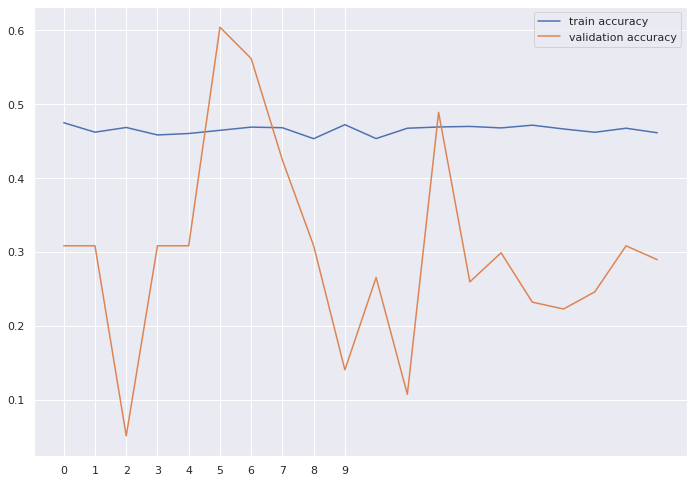

In [ ]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['accuracy'], label='train accuracy')

plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xticks(np.arange(10))
plt.legend()


In [ ]:
model = network()

In [ ]:
!pip install visualkeras ; ! pip install ThreadedFileLoader # module for CNN visualization


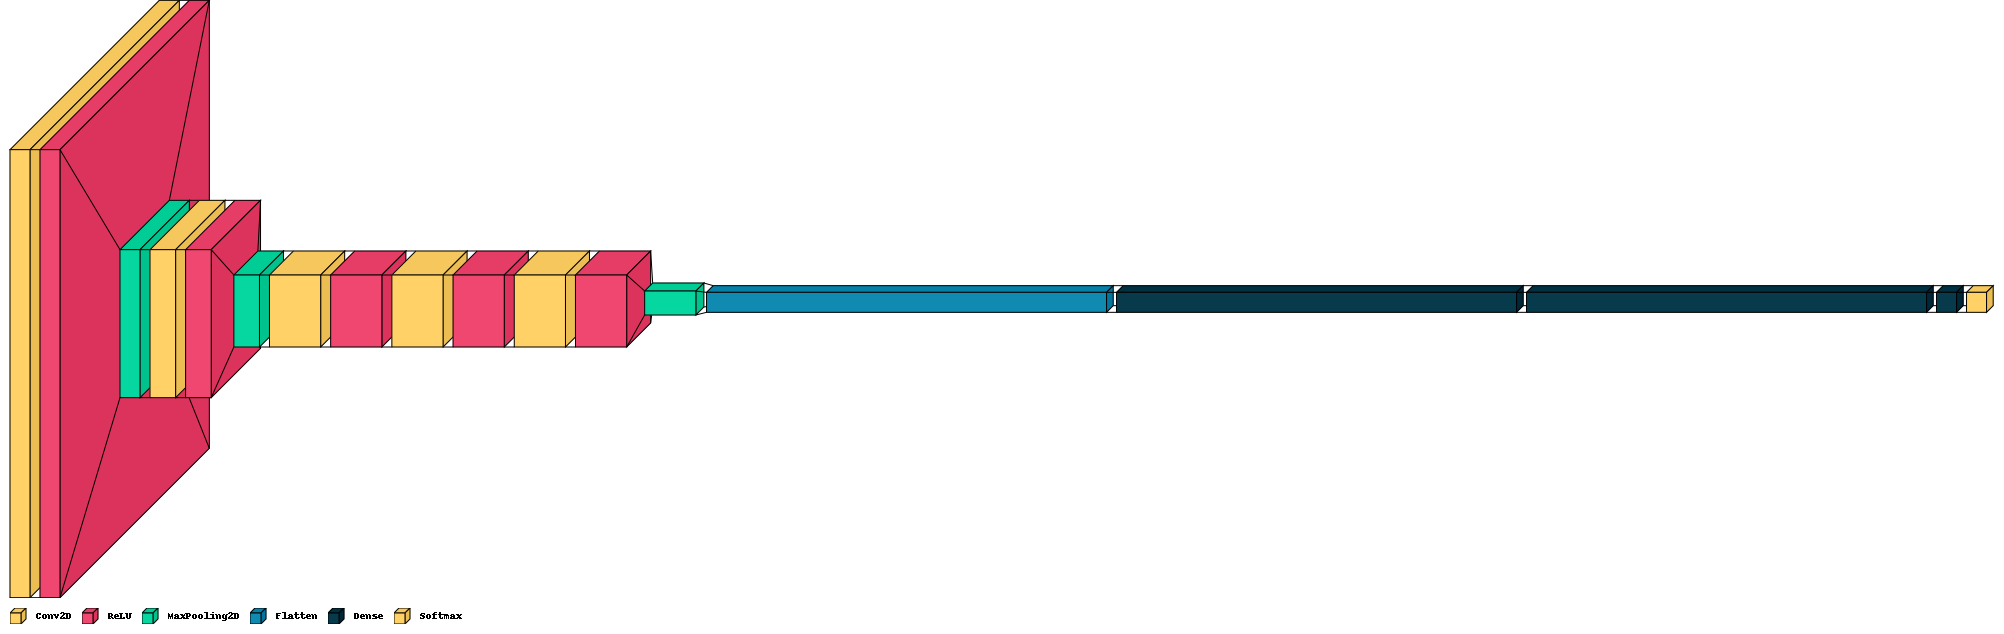

In [ ]:
visualkeras.layered_view(model).show()
visualkeras.layered_view(model,legend=True)

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Track progress
    train_loss_avg.update_state(loss_value)
    train_accuracy.update_state(y, logits)
    return loss_value

In [ ]:
@tf.function
def test_step(x, y, set_name):
    logits = model(x)
    if set_name == 'val':
        val_accuracy.update_state(y, logits)
    else:
        test_accuracy.update_state(y, logits)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
create_log_dir(log_dir, checkpoint_dir)
train_summary_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
train_loss_avg = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.MeanAbsoluteError()
val_accuracy = tf.keras.metrics.MeanAbsoluteError()
test_accuracy = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
for epoch in range(EPOCHS):
    # Training loop
    for x_batch_train, y_batch_train in tqdm(train_set, total=1517):
        # Do step
        loss_value = train_step(x_batch_train, y_batch_train)
        
    # Test on validation set
    for x_batch_val, y_batch_val in val_set:
        test_step(x_batch_val, y_batch_val, 'val')
    
    # Reset training metrics at the end of each epoch
    train_acc = train_accuracy.result()
    train_accuracy.reset_states()
    val_acc = val_accuracy.result()
    val_accuracy.reset_states()
    
    with train_summary_writer.as_default():
        tf.summary.scalar('Train loss', train_loss_avg.result(), step=epoch)
        tf.summary.scalar('Train MAE', train_acc, step=epoch)
        tf.summary.scalar('Val MAE', val_acc, step=epoch)
        
    if epoch % 10 == 0:
        tf.keras.models.save_model(model, '{}/Epoch_{}_model.hp5'.format(checkpoint_dir, str(epoch)), save_format="h5")

 55%|█████▍    | 833/1517 [00:39<00:32, 20.84it/s]


 55%|█████▍    | 833/1517 [00:39<00:32, 20.88it/s]


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir /content/logs

In [ ]:
# Test on validation set
for x_batch_test, y_batch_test in test_set:
    test_step(x_batch_test, y_batch_test, 'test')
test_set_acc = test_accuracy.result()

In [ ]:
display(test_set_acc)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Saving Models

In [ ]:
!zip -r scratch_models.zip /content/checkpoints/scratch_aug

  adding: content/checkpoints/scratch_aug/ (stored 0%)
  adding: content/checkpoints/scratch_aug/Epoch_250_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_0_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_350_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_450_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_100_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_200_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_50_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_400_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_150_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_300_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_500_model.hp5 (deflated 7%)


In [ ]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("/content/tfrecords/train.tfrecords")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

In [ ]:
example


## Testing predictions

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
GCS_PATH = "/"
BATCH_SIZE = 64
IMAGE_SIZE = [1024, 1024]

In [ ]:
model.compile()

In [ ]:
from keras.models import load_model

model =load_model('/content/checkpoints/Epoch_0_model.hp5')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 96)      14208     
                                                                 
 re_lu (ReLU)                (None, 112, 112, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 256)       614656    
                                                                 
 re_lu_1 (ReLU)              (None, 37, 37, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 256)      0         
 2D)                                                    

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/DAiSEE/DAiSEE/DataSet/Data/Train/310082/3100821015/310082101534.jpg')

In [ ]:
image

array([[[[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        [[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        [[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        ...,

        [[0.19215687, 0.26666668, 0.39607844],
         [0.19215798, 0.2666678 , 0.39607957]

In [ ]:
model.predict(image)

array([[1.3776677e-06, 9.9999857e-01, 3.2351309e-18, 0.0000000e+00]],
      dtype=float32)

### Method 2 : RESNET+ TCN 


#### Code Description:

The input is training and validation raw frames extracted from videos and placed in separate folders (using `extractFramesOpenCV.py`). The address of the folders (containing video frames) and corresponding labels should be provided in two csv files, train.csv and validation.csv as follows
 
```python
path,label
/home/videos/train/826412/8264120240/,0
/home/videos/train/510034/5100342024/,1
/home/videos/train/500067/5000671065/,2
...
```

`datasets.py` and `transforms.py` read the video frames based on their address in the csv files, preprocess and normalize them, and convert them to [PyTorch dataloaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

The ResNet-TCN Hybrid Architecture is in `ResTCN.py`. In the class `ResTCN` and the function `forward`, [resnet18](https://pytorch.org/vision/0.8/models.html#torchvision.models.resnet18) extracts features from consecutive frames of video, and [TCN](https://github.com/locuslab/TCN) analyzes changes in the extracted features, and fully-connected layers output the final prediction.

Training and validation phases are performed in `train.py`. Training the ResNet and TCN is performed jointly using [Adam](https://pytorch.org/docs/stable/optim.html) optimization algorithm.

The input to the ResTCN model should have this format: inputs = torch.randn([batch_size, sequence_length, num_channels, frame_width, frame_height]), for instance

```
import torch
from ResTCN import ResTCN
model = ResTCN().cuda()
inputs = torch.randn([16, 30, 3, 256, 256]).cuda()
outputs = model(inputs)
```

The code has been tested on the [DAiSEE](https://iith.ac.in/~daisee-dataset/), Dataset for Affective States in E-Environments, for engagement level classification in online classrooms.



In [ ]:
!git clone https://github.com/aenoboa1/ResNet-TCN

Cloning into 'ResNet-TCN'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 201 (delta 4), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (201/201), 2.65 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [ ]:
from glob import glob
glob("/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/*", recursive = True)


['/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441059',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441022',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441058',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000442057',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000442056',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441067',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441042',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441048',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000442066',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441062',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441068',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000442016',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441045',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000442076',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/5000441041',
 '/content/DAiSEE/DAiSEE/DataSet/Data/Test/500044/50004

## Loading dataimages:

In [ ]:
!mkdir /content/DAiSEE2 ; unzip  -qq /content/drive/MyDrive/DATA/DAiSEE.zip -d /content/DAiSEE2

/content/DAiSEE2/DAiSEE/DataSet/Train/210055/2100552061/2100552061.avi  bad CRC 2993cec4  (should be 713f368f)


In [119]:
!python /content/ResNet-TCN/extractFramesOpenCV.py

Train 342227
Train 200048
Train 210051
Train 226051
Train 210060
Train 210057
Train 310080
Train 181374
Train 210055
[mpeg4 @ 0x55a8616ada80] I cbpy damaged at 16 8
[mpeg4 @ 0x55a8616ada80] Error at MB: 344
Train 303830
Train 411021
Train 110001
Train 310078
Train 110041
Train 350361
Train 334463
Train 310071
Train 310064
Train 290428
Train 110015
Train 310072
Train 459999
Train 200050
Train 110013
Train 400018
Train 110007
Train 310077
Train 522129
Train 210058
Train 310068
Train 210061
Train 110017
Train 337021
Train 110011
Train 110014
Train 110006
Train 310063
Train 248510
Train 240846
Train 200049
Train 411031
Train 310081
Train 310082
Train 210059
Train 202614
Train 310075
Train 310083
Train 210053
Train 210052
Train 200054
Train 310074
Train 310076
Train 310066
Train 110004
Train 110016
Train 110008
Train 414081
Train 205601
Train 110012
Train 310070
Train 310073
Train 401835
Train 310069
Train 110010
Train 110002
Train 111003
Train 310079
Train 110005
Train 210056
Train 310062


In [ ]:
while True:pass


In [124]:
!zip -qqr DAiSEE2.zip /content/DAiSEE2/DAiSEE/ 

In [126]:
!cp DAiSEE2.zip /content/drive/MyDrive/DATA/datasets/

In [ ]:
import torch
import torchvision
import cv2
import os


class VideoFolderPathToTensor(object):

    def __init__(self, max_len=None):
        self.max_len = max_len

    def __call__(self, path):

        file_names = sorted([os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        frames_path = [os.path.join(path, f) for f in file_names]

        frame = cv2.imread(frames_path[0])
        height, width, channels = frame.shape
        num_frames = len(frames_path)

        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            torchvision.transforms.Resize([224, 224])
        ])

        # EXTRACT_FREQUENCY = 18
        EXTRACT_FREQUENCY = 1

        # num_time_steps = int(num_frames / EXTRACT_FREQUENCY)

        num_time_steps = 16
        # num_time_steps = 4

        # (3 x T x H x W), https://pytorch.org/docs/stable/torchvision/models.html
        frames = torch.FloatTensor(channels, num_time_steps, 224, 224)

        for index in range(0, num_time_steps):
            frame = cv2.imread(frames_path[index * EXTRACT_FREQUENCY])
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = torch.from_numpy(frame)
            frame = frame.permute(2, 0, 1)  # (H x W x C) to (C x H x W)
            frame = frame / 255
            if frame.shape[2] != 224:
                frame = frame[:, :, 80:560]
            frame = transform(frame)
            frames[:, index, :, :] = frame.float()

        return frames.permute(1, 0, 2, 3)


In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os


class VideoDataset(Dataset):

    def __init__(self, csv, root, transform=None):

        self.dataframe = pd.read_csv(csv)
        self.transform = transform
        self.root = root

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        label = self.dataframe.iloc[index].label
        video = os.path.join(self.root, self.dataframe.iloc[index].path)
        video = self.transform(video)

        return video, label


In [ ]:
import torchvision
from torch.utils.data import DataLoader


def generate_dataloader(batch_size, csv, root):
    dataset = VideoDataset(csv,
                          root,
                          transform=torchvision.transforms.Compose([VideoFolderPathToTensor()]))

    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=4)



In [ ]:
def get_dataloader(batch_size, csv_train, root_train, csv_test, root_test):
    return {
        'train': generate_dataloader(batch_size, csv_train, root_train),
        'test': generate_dataloader(batch_size, csv_test, root_test)}

In [ ]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

import numpy as np


torch.manual_seed(0)
num_epochs = 10
batch_size = 4
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


dataloader = get_dataloader(batch_size,
                            '/content/Draft_ML_EmotionAPP/labelsTCN/label_train_2.csv',
                            os.path.join(os.getcwd(), '/content/DAiSEE/DAiSEE/DataSet/Data/Train/'),
                            '/content/Draft_ML_EmotionAPP/labelsTCN/label_test_2.csv',
                            os.path.join(os.getcwd(), '/content/DAiSEE/DAiSEE/DataSet/Data/Test/'))

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train', 'test']}

print(dataset_sizes, flush=True)

Device being used: cuda
{'train': 2, 'test': 3}


In [ ]:
import torch.nn as nn
from torch.nn.utils import weight_norm

In [ ]:

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class ResTCN(nn.Module):
    def __init__(self):
        super(ResTCN, self).__init__()

        self.spatial_feat_dim = 32
        self.num_classes = 4
        self.nhid = 128
        self.levels = 8
        self.kernel_size = 7
        self.dropout = .1
        self.channel_sizes = [self.nhid] * self.levels

        self.tcn = TemporalConvNet(
            self.spatial_feat_dim,
            self.channel_sizes,
            kernel_size=self.kernel_size,
            dropout=self.dropout)
        self.linear = nn.Linear(self.channel_sizes[-1], self.num_classes)

        self.model_conv = torchvision.models.resnet18(pretrained=True)
        # for param in self.model_conv.parameters():
        #     param.requires_grad = False

        num_ftrs = self.model_conv.fc.in_features
        # self.model_conv.fc = nn.Linear(num_ftrs, 4)
        self.model_conv.fc = nn.Linear(num_ftrs, self.spatial_feat_dim)
        # self.model_conv.fc = Identity()

        # self.rnn = nn.LSTM(self.spatial_feat_dim, 64, 1, batch_first=True)
        # self.linear = nn.Linear(64, 4)

    def forward(self, data):
        # t = 0
        # x = data[:, t, :, :, :]
        # output = self.model_conv(x)

        z = torch.zeros([data.shape[0], data.shape[1], self.spatial_feat_dim]).cuda()
        for t in range(data.size(1)):
            x = self.model_conv(data[:, t, :, :, :])
            z[:, t, :] = x

        # y, _ = self.rnn(z)
        # output = self.linear(torch.sum(y, dim=1))

        z = z.transpose(1, 2)
        y = self.tcn(z)
        # output = self.linear(y[:, :, -1])
        output = self.linear(torch.sum(y, dim=2))

        return output

In [ ]:
def Build_ResTCN():
      model = ResTCN().to(device)
      # optimizer = optim.Adam(model.parameters(), lr=lr)
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=50, gamma=.1)

      criterion = nn.CrossEntropyLoss().to(device)
      softmax = nn.Softmax()

      for epoch in range(num_epochs):

          for phase in ['train', 'test']:

              running_loss = .0
              y_trues = np.empty([0])
              y_preds = np.empty([0])

              if phase == 'train':
                  model.train()
              else:
                  model.eval()

              for inputs, labels in tqdm(dataloader[phase], disable=True):
                  inputs = inputs.to(device)
                  labels = labels.long().squeeze().to(device)

                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs).squeeze()
                      loss = criterion(outputs, labels)

                      if phase == 'train':
                          optimizer.zero_grad()
                          loss.backward()
                          optimizer.step()

                  running_loss += loss.item() * inputs.size(0)
                  preds = torch.max(softmax(outputs), 1)[1]
                  y_trues = np.append(y_trues, labels.data.cpu().numpy())
                  y_preds = np.append(y_preds, preds.cpu())

              # if phase == 'train':
              #     scheduler.step()

              epoch_loss = running_loss / dataset_sizes[phase]

              print("[{}] Epoch: {}/{} Loss: {} LR: {}".format(
                  phase, epoch + 1, num_epochs, epoch_loss, scheduler.get_last_lr()), flush=True)
              print('\naccuracy\t' + str(accuracy_score(y_trues, y_preds)))
      print('\nconfusion matrix\n' + str(confusion_matrix(y_trues, y_preds)))
      return model


In [ ]:
model = Build_ResTCN()

IndexError: ignored

## Test Predictions Pytorch RESTCN